In [18]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os


In [19]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [20]:
# Load dataset
data_dir = 'dataset_pneumonia_5050'
data_flow = data_gen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2698 images belonging to 2 classes.


In [21]:
# Memisahkan dataset secara manual
x_data, y_data = [], []
for _ in range(len(data_flow)):
    x_batch, y_batch = data_flow.next()
    x_data.append(x_batch)
    y_data.append(y_batch)

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)

# Split dataset menjadi 80% train dan 20% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

In [22]:
# Load arsitektur VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan khusus untuk klasifikasi dataset
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(y_data.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
# Training model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=40,
    batch_size=32
)

Epoch 1/40
68/68 [==============================] - 101s 1s/step - loss: 0.4342 - accuracy: 0.8082 - val_loss: 0.2372 - val_accuracy: 0.9074
Epoch 2/40
68/68 [==============================] - 101s 1s/step - loss: 0.2844 - accuracy: 0.8916 - val_loss: 0.2154 - val_accuracy: 0.9185
Epoch 3/40
68/68 [==============================] - 102s 1s/step - loss: 0.2521 - accuracy: 0.9073 - val_loss: 0.1914 - val_accuracy: 0.9278
Epoch 4/40
68/68 [==============================] - 106s 2s/step - loss: 0.2289 - accuracy: 0.9212 - val_loss: 0.1790 - val_accuracy: 0.9296
Epoch 5/40
68/68 [==============================] - 102s 2s/step - loss: 0.2109 - accuracy: 0.9180 - val_loss: 0.1769 - val_accuracy: 0.9389
Epoch 6/40
68/68 [==============================] - 105s 2s/step - loss: 0.1849 - accuracy: 0.9263 - val_loss: 0.1676 - val_accuracy: 0.9296
Epoch 7/40
68/68 [==============================] - 104s 2s/step - loss: 0.1637 - accuracy: 0.9425 - val_loss: 0.1787 - val_accuracy: 0.9315
Epoch 8/40
68

In [24]:
# Evaluasi Model
y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)


17/17 [==============================] - 20s 1s/step


In [25]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[280   9]
 [ 23 228]]


In [26]:
# Classification report
report = classification_report(y_true, y_pred_classes, target_names=list(data_flow.class_indices.keys()))
print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

      normal       0.92      0.97      0.95       289
   pneumonia       0.96      0.91      0.93       251

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540



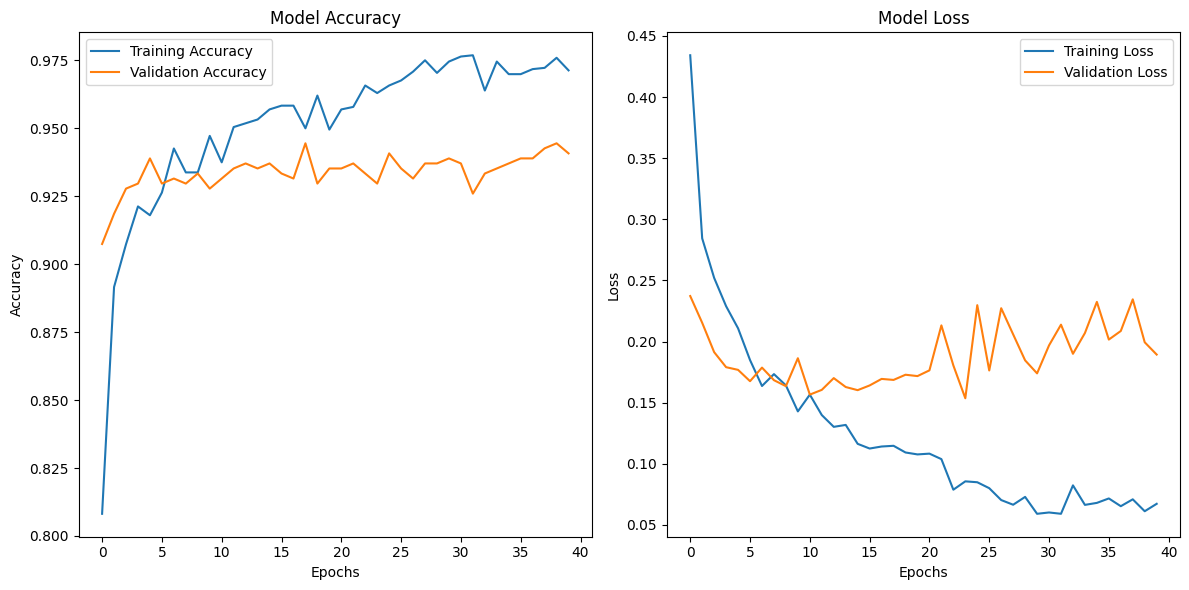

In [27]:
# Visualisasi akurasi dan loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

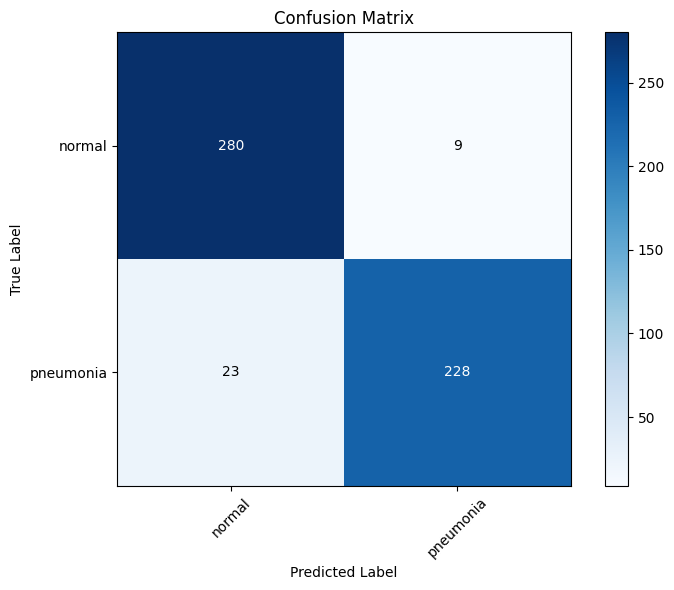

In [28]:
# Visualisasi confusion matrix dengan angka di dalam kotak
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(data_flow.class_indices.keys())
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

# Tambahkan angka di dalam kotak
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [29]:
# Menampilkan metrik
from sklearn.metrics import f1_score, recall_score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {np.mean(y_true == y_pred_classes) * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 94.07%
F1 Score: 0.94
Recall: 0.94
